# Opimisation thèse Manon

### Import des librairies

In [117]:
import numpy as np
import matplotlib.pyplot as plt

from nptyping import NDArray, Float, Shape
from collections.abc import Callable
from mpl_toolkits.mplot3d import axes3d

#Custom type hints
Vector = npt.NDArray[np.float64] # Column vector (n,1)
VectorArray = npt.NDArray[np.float64] # Array (n,N)
ScalarArray = npt.NDArray[np.float64] # Array (1,n)
Matrix = npt.NDArray[np.float64] # Array (n,n)

### Custom type

## Custom plot 3D

### Code

In [118]:
def convert(function: Callable[[VectorArray],float], Xgrid: Matrix, Ygrid: Matrix) -> Matrix:
    """Permet de convertir une fonction prenant un array de points en une fonction prenant une grille (pour l'affichage 3D)."""
    points = np.vstack([Xgrid.flatten(), Ygrid.flatten()])
    Zgrid = function(points)
    return Zgrid.reshape(Xgrid.shape)

In [120]:
def comparaison3DPlot(function_to_plot: Callable[[VectorArray],ScalarArray], 
                      domain: list[Matrix], 
                      function_constrain: Callable[[VectorArray],ScalarArray]=None, 
                      points: VectorArray=None):
    """
    Affichage comparatif (3D et projeté dans le plan) d'une fonction avec affichage de la contrainte et de points si besoin.
    
    La contrainte est respectée si la fonction est positive;
    Le domain (domain) est sous la forme d'une meshgrid;
    """
    # Création de l'espace figure
    fig = plt.figure(figsize=plt.figaspect(0.45),layout='constrained')
    fig.suptitle("Etat de l'optimisation")
    
    # Plot 3D et 2D
    ax3D = fig.add_subplot(1, 2, 2, projection='3d')
    ax2D = fig.add_subplot(1, 2, 1)
    X, Y = domain
    
    # coût
    Zcout = convert(function_to_plot, X, Y)
    surfCout = ax3D.plot_surface(X, Y, Zcout, rstride=1, cstride=1, linewidth=0, antialiased=True, color="purple", alpha=0.6, label="coût")
    flatCout = ax2D.pcolormesh(X, Y, Zcout, cmap="plasma")
    flatContourCout = ax2D.contour(X,Y,Zcout,cmap="Greys")
    
    # contrainte
    if not(function_constrain is None):
        Zcont = convert(function_constrain, X, Y)
        flatCont = ax2D.contour(X,Y,Zcont,levels=[0.])
        contour3DCont = ax3D.contourf(X,Y,Zcont,levels=[np.min(Zcont),0.,np.max(Zcont)],offset=np.min(Zcout),alpha=0.7)
        
        ax2D.clabel(flatCont, fmt="contrainte")
        fig.colorbar(contour3DCont, ax=ax3D, label="contrainte")
        
    # points
    if not(points is None):
        points_2D_2D = ax2D.plot(points[0,:], points[1,:], color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], np.zeros(points[0,:].shape)+np.min(Zcout), color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], function_to_plot(points), color="orange", marker="x", label="points")
        ax2D.legend()
        
    # Cosmétique
    ax3D.grid(True)
    ax3D.set_xlabel('x1')
    ax3D.set_ylabel('x2')
    ax3D.set_zlabel('z')
    ax3D.set_zlim([np.min(Zcout),np.max(Zcout)])
    ax3D.legend()
    ax2D.clabel(flatContourCout, fmt="niveaux coût")
    ax2D.grid(True)
    ax2D.set_xlabel('x1')
    ax2D.set_ylabel('x2')
    fig.colorbar(flatCout, ax=ax2D, label="coût")
    
    plt.show()

### Exemple de plot

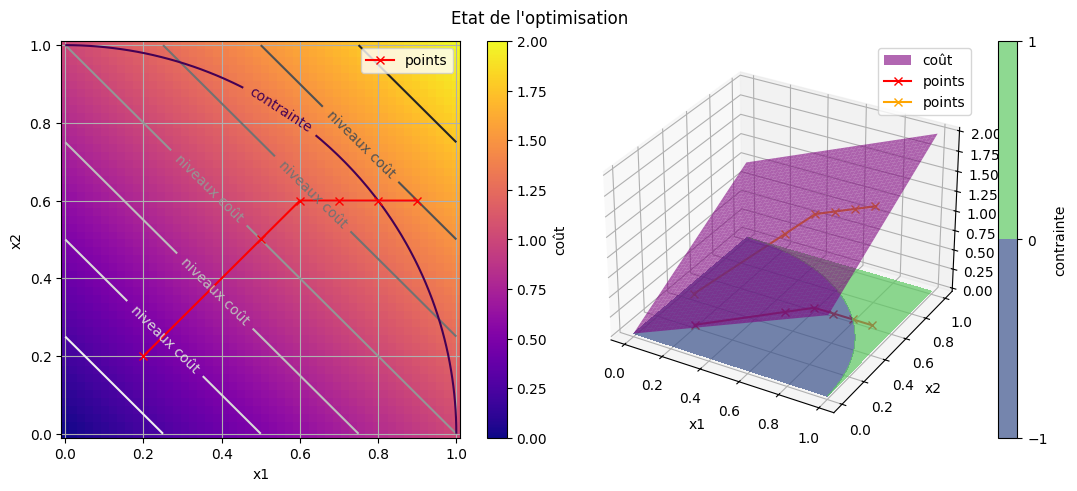

In [121]:
f_test = lambda points: points[0,:]+points[1,:]
h_test = lambda points: points[0,:]**2+points[1,:]**2-1

Xdomain = np.linspace(0,1)
X,Y = np.meshgrid(Xdomain,Xdomain)
points = np.array([[0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.2, 0.5, 0.6, 0.6, 0.6, 0.6]])
        
comparaison3DPlot(f_test,[X,Y],h_test, points)

## Présentation du problème

#### Définition mathématique du problème

On souhaite résoudre le problème suivant :
$$
    \min_{x\in K} f(x), \quad \text{with } K=\{x\in(\mathbb{R}_+^*)^n \vert h(x)\geq 0\}.
$$
Avec :
$$
    f(x)=\sum_{i=1}^n x_i, \quad h(x)=-\text{Module de stabilité de la matrice }A(x)=-\max_{\lambda\in\text{Spec}(A(x))}\text{Re}(\lambda).
$$

### Définitions basiques

#### Elements utiles

In [122]:
# Matrice D (points du graph)
D12=1.4
D21=0.8
D13 = 0.8
D31 = 0.2
D32 = 0.6
D23 = 0.5

D = np.array([[-D21-D31,D12,D13],
              [D21,-D12-D32,D23],
              [D31,D32,-D13-D23]])
# D42 = 0; D52 = 0; D24 = 0; D25=0;D43=0;D53=0;D34=0;D35=0

# Constantes et fonctions
n = np.shape(D)[0] 
I = np.eye(n)
geneGFonc = lambda a,K: lambda x: a-x/K

#### Matrice A(x)

In [123]:
g1= geneGFonc(0.7, 2)
g2= geneGFonc(0.5, 3)
g3= geneGFonc(0.2, 4)

def A(points: VectorArray) -> list[Matrix]:
    """Fonction A optimisée pour le calcul."""
    return [np.diag([g1(0)-p[0],g2(0)-p[1],g3(0)]) +D for p in points.T]

#### Module de stabilité (contrainte)

In [124]:
def h_old(x: Vector) -> float:
    eigv, eigp = np.linalg.eig(A(x))
    real = eigv.real
    return max(real)

def h(points: VectorArray) -> ScalarArray:
    """Fonction h optimisée pour le calcul. En sachant que l'on se met dans le cas """
    return -1*np.array([np.max(np.linalg.eig(matA)[0].real) for matA in A(points)])

#### Coût et affichage

In [125]:
def f(points: VectorArray) -> ScalarArray:
    """Fonction de coût f optimisée."""
    return points[0,:]+points[1,:]

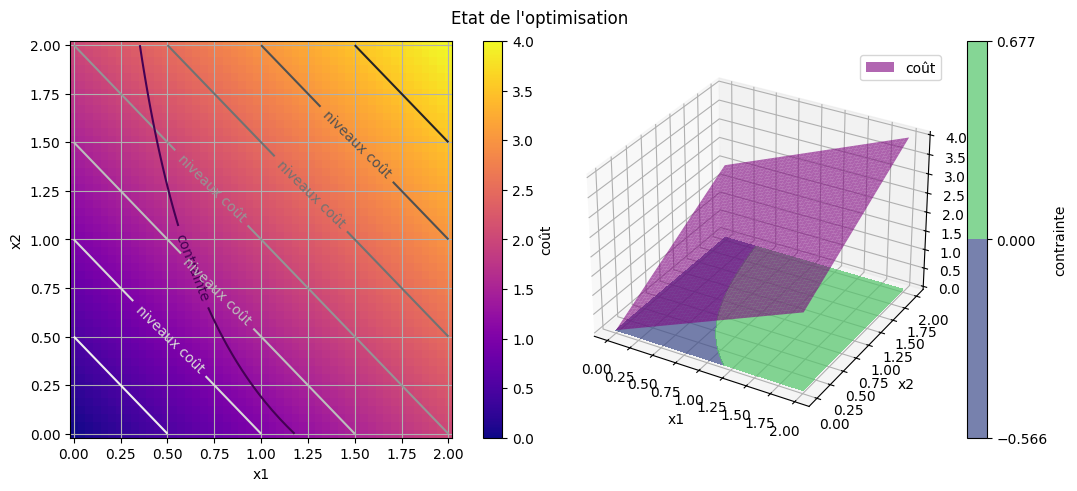

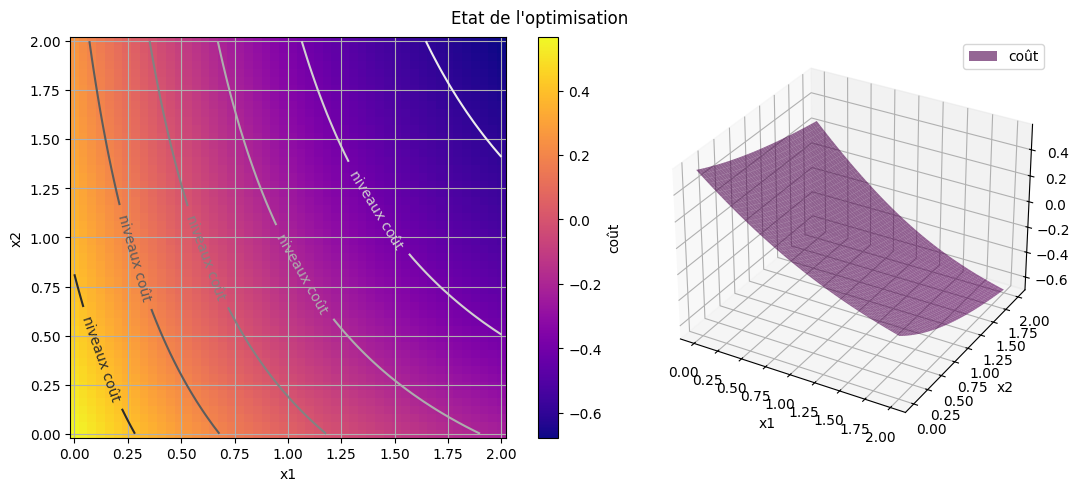

In [134]:
Xdomain = np.linspace(0,2)
X,Y = np.meshgrid(Xdomain,Xdomain)
points = np.array([[0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.2, 0.5, 0.6, 0.6, 0.6, 0.6]])
        
comparaison3DPlot(f,[X,Y],h)
comparaison3DPlot(lambda pts: -1*h(pts),[X,Y])

### Pré-calculs pour l'optimisation

## Optimisation par points intérieurs

### Méthode

On applique la méthode de Newton à la fonction suivante (à $t$ fixé):
$$
    f_{\phi,t}(x)=tf(t)-\phi(x),\quad \phi(x)=\ln(h(x))+\ln(x_i).
$$
A chaque étape on multiplie $t$ par $\mu>1$ jusqu'à ce que $t>1/\varepsilon$.

### Newton

In [131]:
def newton(gradient: Callable[[Vector], Vector], 
           hess: Callable[[Vector], Matrix],
           x0: Vector, tolerance: float, maxIter: int) -> (VectorArray, float, int):
    """Methode de Newton prenant un gradient et une hessienne."""
    # Initialisation
    points = x0.copy()
    x = x0
    nbxIter = 0
    previousGradient = gradient(x)
    error = np.linalg.norm(previousGradient)
    
    # Boucle
    while (error >= tolerance) and (nbxIter <= maxIter):
        deltaX = np.linalg.solve(hess(x), previousGradient)
        x -= deltaX
        
        points = np.concatenate((points, x.copy()), axis=1)
        previousGradient = gradient(x)
        error = np.linalg.norm(previousGradient)
        nbxIter += 1
    
    return points, error, nbxIter

#### Test rapide Newton

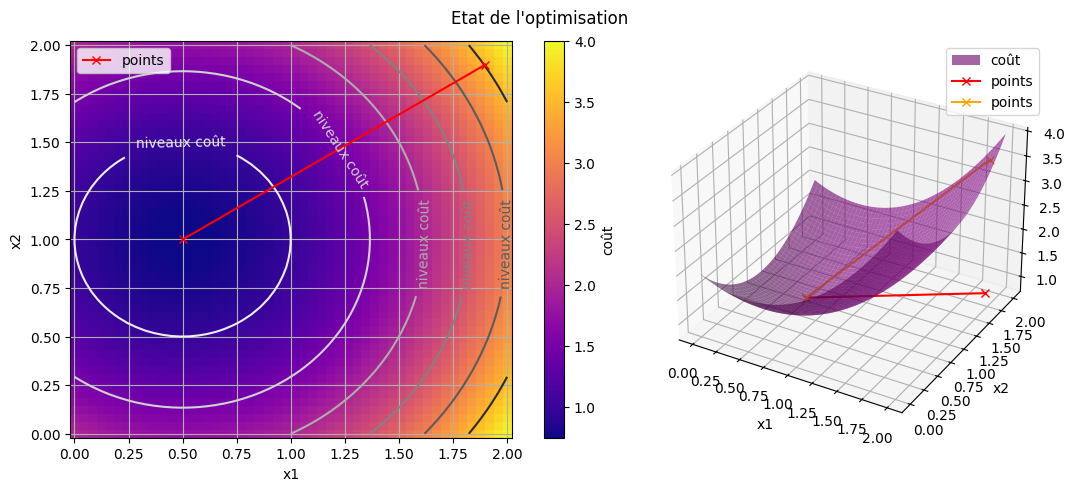

In [132]:
f_test2 = lambda points: (points[0,:]-1)**2+ (points[1,:]-1)**2 + points[0,:]
gradient = lambda x: 2*np.array([[x[0,0]-0.5],[x[1,0]-1]])
hess = lambda x: np.array([[2,0],[0,2]])

Xdomain = np.linspace(0,2)
X,Y = np.meshgrid(Xdomain,Xdomain)
points, error, nbxIter = newton(gradient, hess, np.array([[1.9],[1.9]]), 1e-5, 20)
        
comparaison3DPlot(f_test2,[X,Y],points=points)

### Points intérieurs

In [135]:
def interiorPoint(gradient: Callable[[Vector, float], Vector], 
                  hess: Callable[[Vector, float], Matrix],
                  x0: Vector, tolerance: float, maxIter: int,
                  t0: float, eps: float, mu: float) -> (VectorArray, float, int):
    """Methodes des points intérieurs."""
    # Initialisation
    points = x0.copy()
    x = x0
    nbxIter = 0
    t = t0
    
    # Boucle
    while 1/t>eps and nbxIter <= maxIter:
        pointsNewton, errorNewton, nbxIterNewton = newton(lambda x: gradient(x,t), lambda x: hess(x,t), x, tolerance, maxIter)
        error = errorNewton
        points = np.concatenate((points, pointsNewton.copy()), axis=1)
        
        t = mu*t
        x[:,0] = pointsNewton[:,-1]
        nbxIter += 1
        
    return points, error, nbxIter


#### Test rapide intérieurs

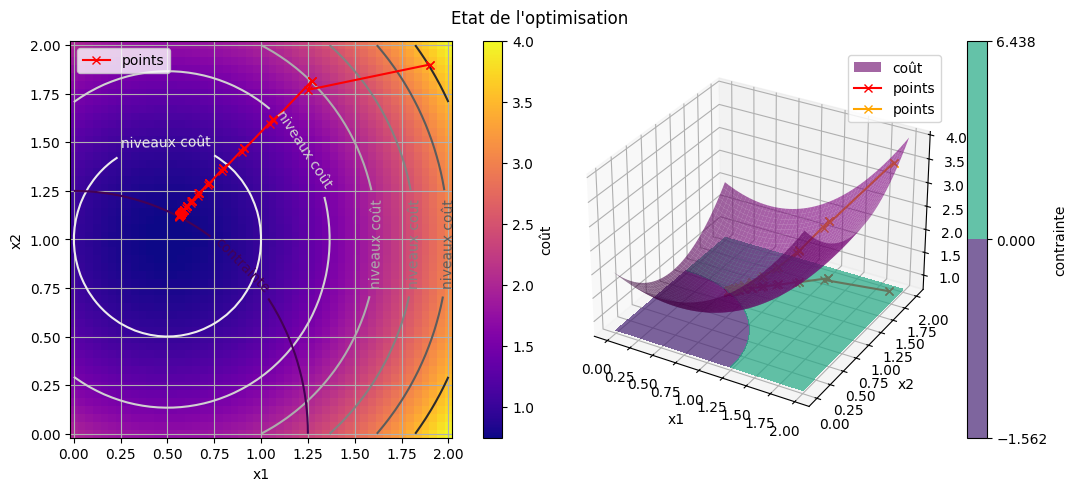

In [149]:
f_test2 = lambda points: (points[0,:]-1)**2+ (points[1,:]-1)**2 + points[0,:]
h_test2 = lambda points: points[0,:]**2+points[1,:]**2-1.25**2

def gradient(x,t):
    gradf = lambda x: 2*np.array([[x[0,0]-0.5],[x[1,0]-1]])
    gradh = lambda x: 2/h_test2(x)*np.array([[x[0,0]],[x[1,0]]])
    gradlog = lambda x: np.array([[1/x[0,0]],[1/x[1,0]]])
    return t*gradf(x)-gradh(x)-gradlog(x)
    
def hess(x,t):
    hessf = lambda x: 2*np.eye(2)
    hessh = lambda x: -4/(h_test2(x)**2)*np.array([[x[0,0]**2, x[0,0]*x[1,0]],[x[0,0]*x[1,0], x[1,0]**2]]) + 2/h_test2(x)*np.eye(2)
    hesslog = lambda x: -np.array([[(1/x[0,0]**2), 0],[0, 1/(x[1,0]**2)]])
    return t*hessf(x)-hessh(x)-hesslog(x)

Xdomain = np.linspace(0,2)
X,Y = np.meshgrid(Xdomain,Xdomain)
points, error, nbxIter = interiorPoint(gradient, hess, np.array([[1.9],[1.9]]), 1e-5, 20, 1, 1e-6, 1.7)
        
comparaison3DPlot(f_test2,[X,Y],h_test2, points)

## Applications